<a href="https://colab.research.google.com/github/cakwok/Computer-Vision/blob/main/fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install cv

      label                                               path
0      FISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
1      FISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
2      FISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
3      FISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
4      FISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
..      ...                                                ...
320  NOFISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
321  NOFISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
322  NOFISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
323  NOFISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...
324  NOFISH  /content/drive/MyDrive/Colab Notebooks/Bruce/H...

[325 rows x 2 columns]
Total training examples: 325
data_list 325
325
torch.Size([8, 3, 224, 224])


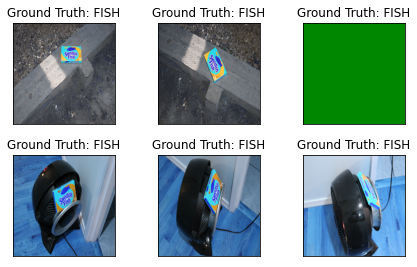

('/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/FISH/IMG_0080.JPG', '/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/FISH/IMG_0081.JPG', '/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/FISH/IMG_0081.CR2', '/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/FISH/IMG_0088.JPG', '/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/FISH/IMG_0089.JPG', '/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/FISH/IMG_0090.JPG', '/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/FISH/IMG_0092.JPG', '/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/FISH/IMG_0094.JPG')


In [7]:

import torch
import torchvision                  
import sys
import matplotlib.pyplot as plt      
import torch.nn as nn               
import torch.nn.functional as F      
import torch.optim as optim
import time
import os
import glob
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Bruce')
import dataloader      

def check_processor():
    
    if torch.cuda.is_available():
        device = 'cuda'
        print('Using cuda\n')
    else:
        device = 'cpu'
        print('Using cpu\n')
        
    return device

class FishNet(nn.Module):               
    def __init__(self):                       
        super(FishNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)   
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)   
        self.conv1_drop = nn.Dropout2d(p=0.5)                
        self.conv2_drop = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(320, 50)                  
        self.fc2 = nn.Linear(50, 10)                   

    def forward(self, x):                               
        x = F.relu(F.max_pool2d(self.conv1(x), 2))      
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))  
        x = x.view(-1, 320)                             
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training) #??? still need???
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

'''
def train(epoch, network, train_loader, optimizer, log_interval, train_losses, train_counter):          
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()                          
        output = network(data)                  
        loss = F.nll_loss(output, target)               
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(network.state_dict(), './results/model.pth')        
            #torch.save(optimizer.state_dict(), './results/optimizer.pth')   
'''
def test(network, test_loader, test_losses):                                                    
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            #print ("Ground Truth", target)
            #print ("log_softmax(x)", output)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))


def train(**config):   
     
    torch.cuda.empty_cache()
    
    # -------- Prepare dataset and dataloader
    start_time = time.time()            
    torch.manual_seed(42)           
    torch.backends.cudnn.enabled = False    

    Fish_net = FishNet().cuda()
    
    image_label_df = pd.DataFrame()

    #if config["load_pretrain"] == True:
    #    DCE_net.load_state_dict(torch.load(config["pretrain_dir"]))

    for root, dirs, files in os.walk(config["fish_images_path"]):
      for file in files:
        label = root.split("/")[-1]
        if label == "FISH" or label == "NOFISH":
          image_label_df = image_label_df.append({"label": label, 'path': os.path.join(root,file)}, ignore_index = True)
        
    print(image_label_df)

    train, valid = train_test_split(image_label_df, test_size=0.1,random_state=0)
        
    train_dataset = dataloader.fish_loader(image_label_df)		
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config["train_batch_size"], shuffle=False)

    optimizer = torch.optim.Adam(Fish_net.parameters(), lr=config["lr"])

    Fish_net.train()
    
    examples = enumerate(train_loader)

    #next - read the first enumerated element
    batch_idx, (example_data, example_targets, data_path) = next(examples)

    #See one test data batch consists of torch.Size([1000, 1, 28, 28])
    #1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one)
    print (example_data.shape)

    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.tight_layout()
        plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([]); plt.yticks([])

        images_rgb = example_data[i].squeeze()
        images_rgb = (np.transpose(images_rgb, (0, 2, 1)).T).detach().numpy()
        plt.imshow(cv2.cvtColor(images_rgb, cv2.COLOR_BGR2RGB))

    plt.show()
    print(data_path)

    '''

    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        plt.title("Ground Truth: {}".format(id2label[str(labels[i])]))
        
        images_rgb = images[i].squeeze()
        images_rgb = (np.transpose(images_rgb, (0, 2, 1)).T).detach().numpy()
        plt.imshow(cv2.cvtColor(images_rgb, cv2.COLOR_BGR2RGB))
        
        print(img_name[i])


    NeuralNetwork1 = NeuralNetwork()                                                         #Initialize Neural Networks
    optimizer = optim.SGD(NeuralNetwork1.parameters(), lr=learning_rate, momentum=momentum)        #Initialize optimizer

    train_losses = []                                                                        #Question 1D Train the model
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    test(NeuralNetwork1, test_loader, test_losses)                                           #Run test once to see accuracy

    for epoch in range(1, n_epochs + 1):                                                     #Run training of network
        train(epoch, NeuralNetwork1, train_loader, optimizer, log_interval, train_losses, train_counter)
        test(NeuralNetwork1, test_loader, test_losses)


    fig = plt.figure()                                                                      #Plot of training and testing error
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    plt.show()
    '''
    return

if __name__ == "__main__":
    
  #main(sys.argv)

  config = {
    "fish_images_path" : "/content/drive/MyDrive/Colab Notebooks/Bruce/HeatherCannonT7/JPG/",
    "lr": 0.001,
    "num_epochs" : 20, 
    "train_batch_size" : 8,
    "val_batch_size" : 4,
    "load_pretrain": False,
    #"pretrain_dir" : "/content/drive/MyDrive/Colab Notebooks/CS7180 Project2 Zero DCE-NET/Epoch99.pth"
  }

  train(**config)
